In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
import os
from glob import glob

train_dir = "/kaggle/input/mammography-breast-cancer-detection/train"

benign_images = glob(os.path.join(train_dir, "0", "*.png"))
malignant_images = glob(os.path.join(train_dir, "1", "*.png"))

print(f"Benign count: {len(benign_images)}")
print(f"Malignant count: {len(malignant_images)}")

Benign count: 53548
Malignant count: 1158


In [3]:
# USER PARAMETERS (edit if required)
# ----------------------
train_dir = "/kaggle/input/mammography-breast-cancer-detection/train"  # original dataset root with subfolders 0 and 1
malignant_dir = os.path.join(train_dir, "1")
benign_dir = os.path.join(train_dir, "0")

img_size = 128               # image size used through pipeline (128 recommended)
latent_dim = 100
batch_size = 32              # reduce if OOM
num_epochs = 1500            # GAN epochs requested
save_every = 100             # checkpoint & samples saved every `save_every` epochs
target_malignant_total = 52000  # target number of malignant images after synthetic generation

output_base = "/kaggle/working/breast_gan_pipeline"  # where generated files/models will be saved
os.makedirs(output_base, exist_ok=True)
synthetic_dir = os.path.join(output_base, "synthetic_malignant")
os.makedirs(synthetic_dir, exist_ok=True)
combined_dir = os.path.join(output_base, "combined_dataset")
os.makedirs(combined_dir, exist_ok=True)
combined_malignant_dir = os.path.join(combined_dir, "1")
combined_benign_dir = os.path.join(combined_dir, "0")
os.makedirs(combined_malignant_dir, exist_ok=True)
os.makedirs(combined_benign_dir, exist_ok=True)

CHECKPOINT_PATH = os.path.join(output_base, "gan_checkpoint.pth")
PRETRAINED_GEN = os.path.join(output_base, "pretrained_generator.pth")
GEN_PATH = os.path.join(output_base, "generator.pth")
DISC_PATH = os.path.join(output_base, "discriminator.pth")
CLASSIFIER_PATH = os.path.join(output_base, "classifier.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


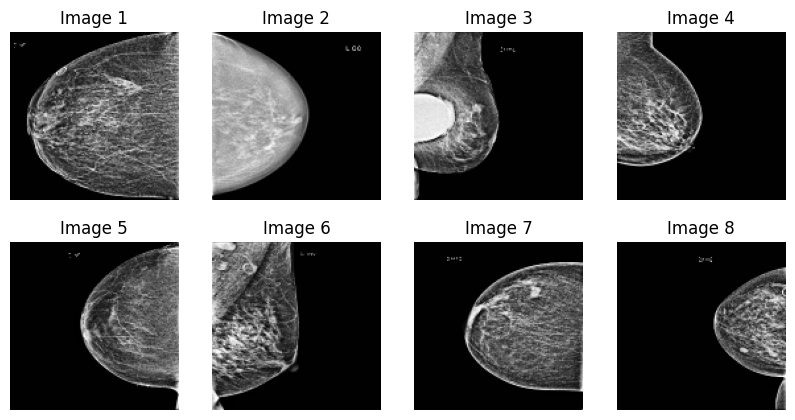

In [4]:
# =========================================================
# Improved Preprocessing for DCGAN
# =========================================================
from torch.utils.data import Dataset
from glob import glob
import cv2
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

img_size = 128

def preprocess_image(img_path):
    # Read as grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    
    # Resize
    img = cv2.resize(img, (img_size, img_size))
    
    # Convert to float32 and normalize to [-1, 1]
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5   # scale to [-1, 1]
    
    # Add channel dimension for grayscale (1, H, W)
    img = np.expand_dims(img, axis=0)
    return img


# Dataset class for single class
class SingleClassDataset(Dataset):
    def __init__(self, folder_path):
        self.img_paths = glob(os.path.join(folder_path, "*.png"))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = preprocess_image(img_path)
        img = torch.tensor(img, dtype=torch.float)
        return img, 1  # label is not used in GAN


# =========================================================
# Test preprocessing by showing some images
# =========================================================
malignant_dir = "/kaggle/input/mammography-breast-cancer-detection/train/1"
dataset = SingleClassDataset(malignant_dir)

# Show first 8 preprocessed images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    img, _ = dataset[i]
    img_np = img.squeeze(0).numpy()  # remove channel dimension
    axes[i//4, i%4].imshow(img_np, cmap="gray")
    axes[i//4, i%4].axis("off")
    axes[i//4, i%4].set_title(f"Image {i+1}")
plt.show()

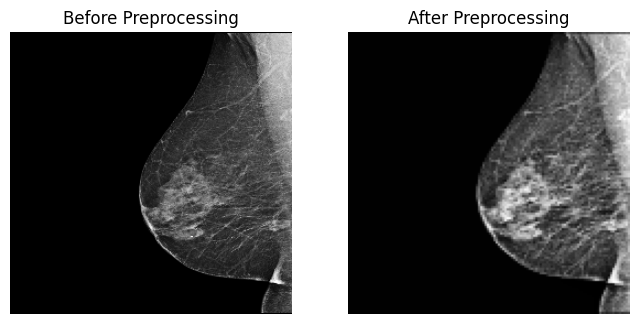

In [5]:
# Pick a random image from malignant class
malignant_dir = "/kaggle/input/mammography-breast-cancer-detection/train/1"
img_path = random.choice(os.listdir(malignant_dir))
img_full_path = os.path.join(malignant_dir, img_path)

# Load raw (original) image
raw_img = cv2.imread(img_full_path, cv2.IMREAD_GRAYSCALE)

# Apply preprocessing
processed_img = preprocess_image(img_full_path)  # Uses your existing function
processed_img = processed_img.squeeze(0)  # Remove channel dimension for plotting

# Plot before and after
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(raw_img, cmap='gray')
plt.title("Before Preprocessing")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_img, cmap='gray')
plt.title("After Preprocessing")
plt.axis('off')

plt.show()

Counts - benign, malignant:
53548 1158
Showing some preprocessed malignant samples:


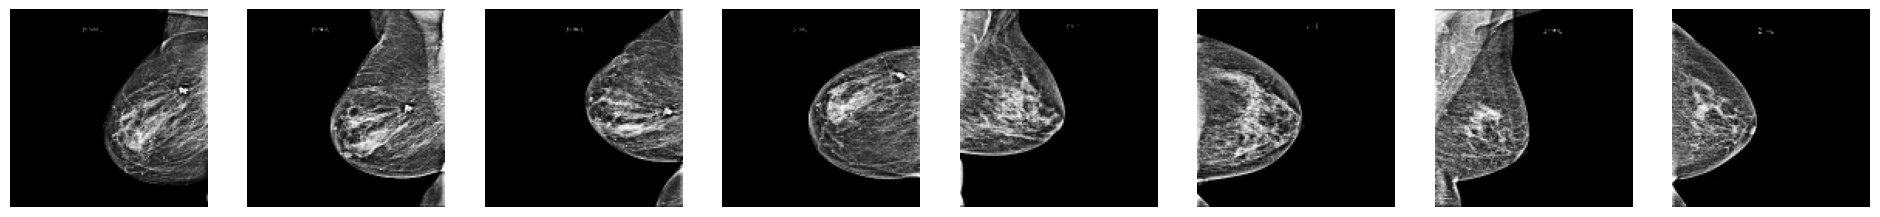

In [6]:
# Preprocessing helpers
# ----------------------
def preprocess_image_array(img, size=img_size):
    # input: grayscale numpy image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img = cv2.resize(img, (size, size))
    img = img.astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5   # normalize to [-1,1]
    img = np.expand_dims(img, 0)  # (1, H, W)
    return img

def preprocess_image_path(path, size=img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise RuntimeError("Cannot read: " + str(path))
    return preprocess_image_array(img, size)

# quick visualize some samples (real malignant)
def show_preprocessed_samples(folder, n=8):
    files = sorted(glob(os.path.join(folder, "*.png")) + glob(os.path.join(folder, "*.jpg")))
    files = files[:n]
    fig, axes = plt.subplots(1, n, figsize=(3*n,3))
    for i,f in enumerate(files):
        arr = preprocess_image_path(f)
        axes[i].imshow(arr.squeeze(0), cmap='gray')
        axes[i].axis('off')
    plt.show()

print("Counts - benign, malignant:")
print(len(glob(os.path.join(benign_dir,"*.png")))+len(glob(os.path.join(benign_dir,"*.jpg"))),
      len(glob(os.path.join(malignant_dir,"*.png")))+len(glob(os.path.join(malignant_dir,"*.jpg"))))

print("Showing some preprocessed malignant samples:")
show_preprocessed_samples(malignant_dir, n=8)

In [7]:
# ----------------------
# Dataset / Loader
# ----------------------
class SingleClassDataset(Dataset):
    def __init__(self, folder_path, size=img_size):
        self.files = sorted(glob(os.path.join(folder_path, "*.png")) + glob(os.path.join(folder_path, "*.jpg")))
        self.size = size
        if len(self.files) == 0:
            raise RuntimeError(f"No images found in {folder_path}")
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        p = self.files[idx]
        arr = preprocess_image_path(p, self.size)  # (1,H,W)
        return torch.tensor(arr, dtype=torch.float32), 1

# loader for malignant only (GAN trains only on malignant)
malignant_dataset = SingleClassDataset(malignant_dir, size=img_size)
malignant_loader = DataLoader(malignant_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

print("Malignant dataset size:", len(malignant_dataset))

Malignant dataset size: 1158


In [8]:
# DCGAN models (for 128x128)
# ----------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),    # -> 64 x 64 x 64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # -> 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False), # -> 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False), # -> 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),# -> 1024 x 4 x 4
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),  # -> 1 x 1 x 1
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x).view(-1)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0, bias=False), # -> 1024 x 4 x 4
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),        # -> 512 x 8 x 8
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),         # -> 256 x 16 x 16
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),         # -> 128 x 32 x 32
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),          # -> 64 x 64 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),            # -> 1 x 128 x 128
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣ Define Generator & Discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

# 2️⃣ Define loss function & optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# Latent vector size must match the one used in training
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)


In [11]:
import os
from glob import glob
import time          # <-- add this
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np


Epoch [1/1500] Loss_D: 0.5022 Loss_G: 5.0735 time:8.2s
Epoch [2/1500] Loss_D: 1.3223 Loss_G: 2.9235 time:6.2s
Epoch [3/1500] Loss_D: 3.7278 Loss_G: 0.8201 time:6.2s
Epoch [4/1500] Loss_D: 1.1776 Loss_G: 2.6959 time:6.3s
Epoch [5/1500] Loss_D: 1.0367 Loss_G: 3.3280 time:6.4s
Epoch [6/1500] Loss_D: 0.5236 Loss_G: 2.7316 time:6.6s
Epoch [7/1500] Loss_D: 1.4191 Loss_G: 1.3127 time:6.5s
Epoch [8/1500] Loss_D: 0.8487 Loss_G: 2.3204 time:6.6s
Epoch [9/1500] Loss_D: 2.9808 Loss_G: 1.9367 time:6.7s
Epoch [10/1500] Loss_D: 1.3349 Loss_G: 1.7815 time:6.8s
Epoch [11/1500] Loss_D: 1.1602 Loss_G: 2.9262 time:6.8s
Epoch [12/1500] Loss_D: 0.7205 Loss_G: 2.8719 time:7.0s
Epoch [13/1500] Loss_D: 1.2325 Loss_G: 4.2514 time:7.1s
Epoch [14/1500] Loss_D: 0.8298 Loss_G: 1.7106 time:7.2s
Epoch [15/1500] Loss_D: 0.5634 Loss_G: 2.2975 time:7.3s
Epoch [16/1500] Loss_D: 3.2589 Loss_G: 1.4958 time:7.5s
Epoch [17/1500] Loss_D: 1.1451 Loss_G: 1.9643 time:7.6s
Epoch [18/1500] Loss_D: 0.3933 Loss_G: 3.7576 time:7.8s
E

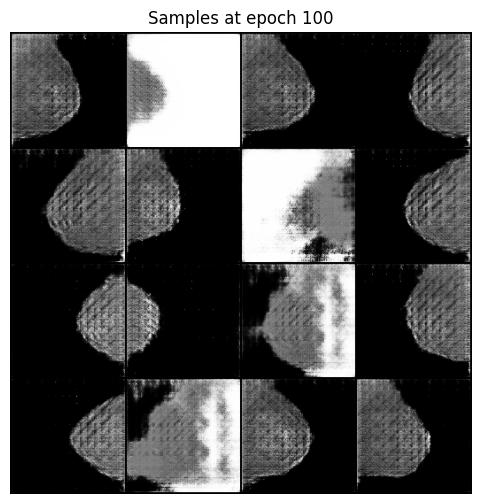

Epoch [101/1500] Loss_D: 0.4741 Loss_G: 2.7259 time:7.5s
Epoch [102/1500] Loss_D: 0.3945 Loss_G: 5.0492 time:7.5s
Epoch [103/1500] Loss_D: 0.3911 Loss_G: 4.8824 time:7.5s
Epoch [104/1500] Loss_D: 0.4140 Loss_G: 3.2842 time:7.5s
Epoch [105/1500] Loss_D: 5.8215 Loss_G: 0.8221 time:7.5s
Epoch [106/1500] Loss_D: 0.3458 Loss_G: 5.4884 time:7.5s
Epoch [107/1500] Loss_D: 5.2417 Loss_G: 0.8102 time:7.5s
Epoch [108/1500] Loss_D: 6.8802 Loss_G: 1.9898 time:7.5s
Epoch [109/1500] Loss_D: 0.6792 Loss_G: 2.8047 time:7.5s
Epoch [110/1500] Loss_D: 2.6052 Loss_G: 0.5625 time:7.5s
Epoch [111/1500] Loss_D: 4.7410 Loss_G: 1.5038 time:7.5s
Epoch [112/1500] Loss_D: 0.3992 Loss_G: 3.7331 time:7.5s
Epoch [113/1500] Loss_D: 0.3468 Loss_G: 4.3394 time:7.5s
Epoch [114/1500] Loss_D: 0.4259 Loss_G: 5.2321 time:7.5s
Epoch [115/1500] Loss_D: 2.0091 Loss_G: 3.3479 time:7.5s
Epoch [116/1500] Loss_D: 0.5872 Loss_G: 2.1739 time:7.5s
Epoch [117/1500] Loss_D: 1.0983 Loss_G: 3.7413 time:7.5s
Epoch [118/1500] Loss_D: 2.9623

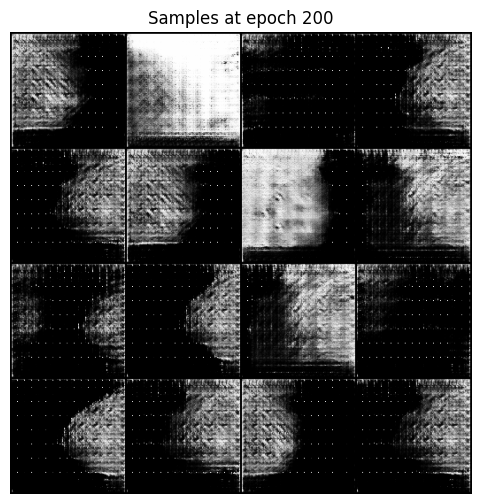

Epoch [201/1500] Loss_D: 6.1051 Loss_G: 2.1027 time:7.5s
Epoch [202/1500] Loss_D: 0.3744 Loss_G: 6.8188 time:7.5s
Epoch [203/1500] Loss_D: 0.3378 Loss_G: 6.5994 time:7.5s
Epoch [204/1500] Loss_D: 0.4093 Loss_G: 6.9946 time:7.5s
Epoch [205/1500] Loss_D: 4.1615 Loss_G: 4.0640 time:7.5s
Epoch [206/1500] Loss_D: 0.3498 Loss_G: 4.5330 time:7.6s
Epoch [207/1500] Loss_D: 0.4275 Loss_G: 4.6248 time:7.5s
Epoch [208/1500] Loss_D: 0.3887 Loss_G: 5.3399 time:7.5s
Epoch [209/1500] Loss_D: 0.3333 Loss_G: 6.7873 time:7.5s
Epoch [210/1500] Loss_D: 0.3433 Loss_G: 6.6258 time:7.5s
Epoch [211/1500] Loss_D: 0.3402 Loss_G: 6.9545 time:7.5s
Epoch [212/1500] Loss_D: 0.3530 Loss_G: 4.0259 time:7.5s
Epoch [213/1500] Loss_D: 0.3766 Loss_G: 4.5337 time:7.7s
Epoch [214/1500] Loss_D: 0.4031 Loss_G: 4.7683 time:7.7s
Epoch [215/1500] Loss_D: 7.5519 Loss_G: 1.3287 time:7.7s
Epoch [216/1500] Loss_D: 0.3415 Loss_G: 4.3116 time:7.5s
Epoch [217/1500] Loss_D: 5.2186 Loss_G: 1.3014 time:7.5s
Epoch [218/1500] Loss_D: 3.8105

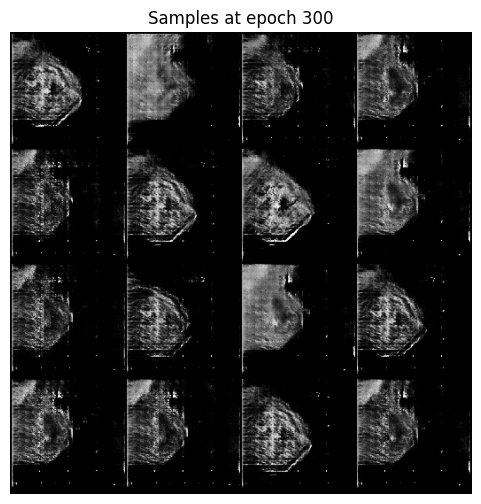

Epoch [301/1500] Loss_D: 0.4135 Loss_G: 6.2466 time:7.6s
Epoch [302/1500] Loss_D: 0.4384 Loss_G: 5.1074 time:7.7s
Epoch [303/1500] Loss_D: 0.4119 Loss_G: 5.8799 time:7.6s
Epoch [304/1500] Loss_D: 3.5994 Loss_G: 0.3649 time:7.6s
Epoch [305/1500] Loss_D: 0.3306 Loss_G: 6.7244 time:7.6s
Epoch [306/1500] Loss_D: 0.3263 Loss_G: 8.0398 time:7.7s
Epoch [307/1500] Loss_D: 0.4959 Loss_G: 4.4092 time:7.6s
Epoch [308/1500] Loss_D: 0.3466 Loss_G: 4.3655 time:7.7s
Epoch [309/1500] Loss_D: 0.3447 Loss_G: 4.9002 time:7.7s
Epoch [310/1500] Loss_D: 0.3648 Loss_G: 6.3655 time:7.5s
Epoch [311/1500] Loss_D: 7.6061 Loss_G: 0.6083 time:7.5s
Epoch [312/1500] Loss_D: 7.2092 Loss_G: 0.9840 time:7.5s
Epoch [313/1500] Loss_D: 6.5777 Loss_G: 1.5699 time:7.5s
Epoch [314/1500] Loss_D: 0.3347 Loss_G: 5.9064 time:7.5s
Epoch [315/1500] Loss_D: 6.2201 Loss_G: 1.9506 time:7.5s
Epoch [316/1500] Loss_D: 0.3359 Loss_G: 5.2055 time:7.5s
Epoch [317/1500] Loss_D: 1.6591 Loss_G: 1.6942 time:7.5s
Epoch [318/1500] Loss_D: 4.0179

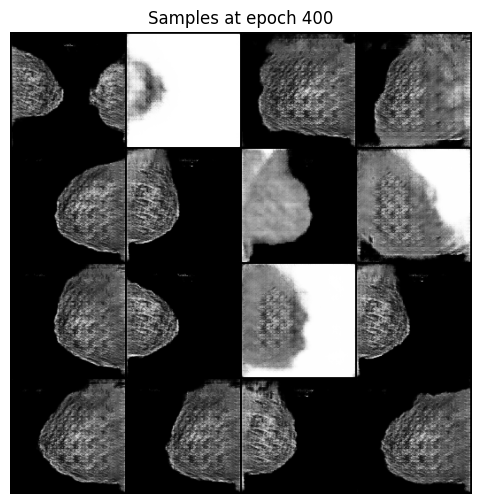

Epoch [401/1500] Loss_D: 2.5808 Loss_G: 0.4789 time:7.5s
Epoch [402/1500] Loss_D: 2.7618 Loss_G: 3.6552 time:7.7s
Epoch [403/1500] Loss_D: 0.5056 Loss_G: 5.0854 time:7.7s
Epoch [404/1500] Loss_D: 0.7139 Loss_G: 3.6432 time:7.6s
Epoch [405/1500] Loss_D: 1.7914 Loss_G: 3.4789 time:7.6s
Epoch [406/1500] Loss_D: 0.4775 Loss_G: 3.6071 time:7.6s
Epoch [407/1500] Loss_D: 0.6790 Loss_G: 2.8144 time:7.6s
Epoch [408/1500] Loss_D: 0.7564 Loss_G: 2.5567 time:7.7s
Epoch [409/1500] Loss_D: 0.7768 Loss_G: 2.8959 time:7.7s
Epoch [410/1500] Loss_D: 1.1530 Loss_G: 1.4689 time:7.6s
Epoch [411/1500] Loss_D: 0.3684 Loss_G: 6.8214 time:7.6s
Epoch [412/1500] Loss_D: 1.1143 Loss_G: 3.0311 time:7.6s
Epoch [413/1500] Loss_D: 0.3633 Loss_G: 5.4724 time:7.6s
Epoch [414/1500] Loss_D: 7.7319 Loss_G: 1.2642 time:7.5s
Epoch [415/1500] Loss_D: 4.8599 Loss_G: 0.5501 time:7.5s
Epoch [416/1500] Loss_D: 4.8239 Loss_G: 1.5983 time:7.7s
Epoch [417/1500] Loss_D: 0.3941 Loss_G: 5.4777 time:7.6s
Epoch [418/1500] Loss_D: 0.3396

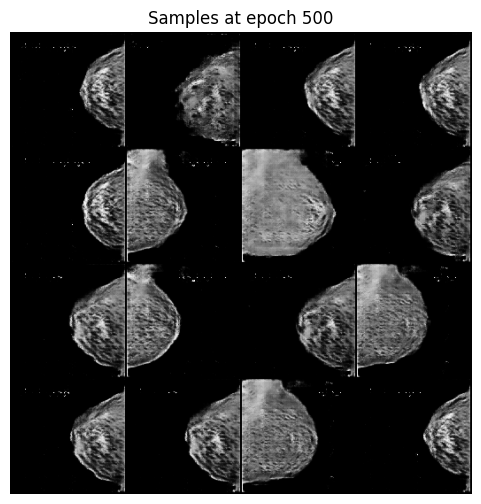

Epoch [501/1500] Loss_D: 0.3291 Loss_G: 6.1052 time:7.5s
Epoch [502/1500] Loss_D: 5.7493 Loss_G: 3.5001 time:7.5s
Epoch [503/1500] Loss_D: 0.3444 Loss_G: 4.0205 time:7.5s
Epoch [504/1500] Loss_D: 0.4705 Loss_G: 3.5300 time:7.5s
Epoch [505/1500] Loss_D: 5.9818 Loss_G: 2.8917 time:7.5s
Epoch [506/1500] Loss_D: 5.1561 Loss_G: 1.5613 time:7.5s
Epoch [507/1500] Loss_D: 5.0293 Loss_G: 1.6704 time:7.5s
Epoch [508/1500] Loss_D: 5.5693 Loss_G: 1.5822 time:7.6s
Epoch [509/1500] Loss_D: 0.3417 Loss_G: 5.7354 time:7.6s
Epoch [510/1500] Loss_D: 0.6425 Loss_G: 3.5564 time:7.5s
Epoch [511/1500] Loss_D: 6.3524 Loss_G: 3.8455 time:7.5s
Epoch [512/1500] Loss_D: 4.3077 Loss_G: 3.6788 time:7.5s
Epoch [513/1500] Loss_D: 5.7481 Loss_G: 2.7512 time:7.6s
Epoch [514/1500] Loss_D: 0.3342 Loss_G: 4.4577 time:7.7s
Epoch [515/1500] Loss_D: 0.3740 Loss_G: 3.4462 time:7.7s
Epoch [516/1500] Loss_D: 0.3335 Loss_G: 4.4634 time:7.5s
Epoch [517/1500] Loss_D: 0.3299 Loss_G: 5.6323 time:7.5s
Epoch [518/1500] Loss_D: 0.3293

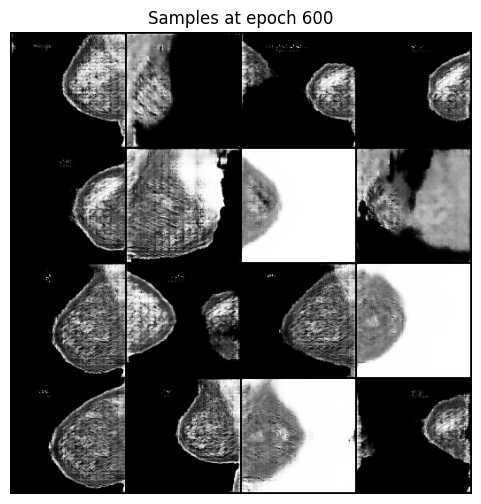

Epoch [601/1500] Loss_D: 0.3361 Loss_G: 7.4215 time:7.5s
Epoch [602/1500] Loss_D: 2.1341 Loss_G: 6.6786 time:7.5s
Epoch [603/1500] Loss_D: 0.3531 Loss_G: 4.4366 time:7.5s
Epoch [604/1500] Loss_D: 1.5249 Loss_G: 0.9034 time:7.5s
Epoch [605/1500] Loss_D: 0.3655 Loss_G: 6.7665 time:7.6s
Epoch [606/1500] Loss_D: 0.8191 Loss_G: 6.2462 time:7.6s
Epoch [607/1500] Loss_D: 0.3415 Loss_G: 5.3629 time:7.5s
Epoch [608/1500] Loss_D: 0.8018 Loss_G: 2.0987 time:7.5s
Epoch [609/1500] Loss_D: 0.9514 Loss_G: 1.6680 time:7.7s
Epoch [610/1500] Loss_D: 0.4821 Loss_G: 3.3529 time:7.7s
Epoch [611/1500] Loss_D: 0.4011 Loss_G: 5.4727 time:7.7s
Epoch [612/1500] Loss_D: 0.4518 Loss_G: 6.7757 time:7.7s
Epoch [613/1500] Loss_D: 0.3623 Loss_G: 9.2606 time:7.5s
Epoch [614/1500] Loss_D: 0.6162 Loss_G: 3.6589 time:7.7s
Epoch [615/1500] Loss_D: 1.3579 Loss_G: 5.2103 time:7.6s
Epoch [616/1500] Loss_D: 0.4104 Loss_G: 4.6453 time:7.5s
Epoch [617/1500] Loss_D: 1.0546 Loss_G: 6.9624 time:7.6s
Epoch [618/1500] Loss_D: 1.4115

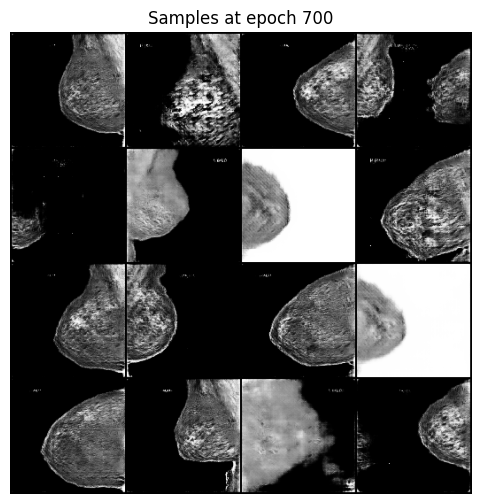

Epoch [701/1500] Loss_D: 0.3763 Loss_G: 4.3141 time:7.5s
Epoch [702/1500] Loss_D: 1.4689 Loss_G: 5.5208 time:7.5s
Epoch [703/1500] Loss_D: 0.3452 Loss_G: 6.7461 time:7.5s
Epoch [704/1500] Loss_D: 0.3846 Loss_G: 5.1136 time:7.5s
Epoch [705/1500] Loss_D: 0.7384 Loss_G: 2.2819 time:7.5s
Epoch [706/1500] Loss_D: 0.5412 Loss_G: 3.3797 time:7.5s
Epoch [707/1500] Loss_D: 0.4209 Loss_G: 3.6066 time:7.5s
Epoch [708/1500] Loss_D: 2.3363 Loss_G: 6.6264 time:7.5s
Epoch [709/1500] Loss_D: 0.6083 Loss_G: 4.0557 time:7.5s
Epoch [710/1500] Loss_D: 2.5857 Loss_G: 1.6037 time:7.5s
Epoch [711/1500] Loss_D: 0.9779 Loss_G: 4.8760 time:7.5s
Epoch [712/1500] Loss_D: 0.8493 Loss_G: 5.1968 time:7.5s
Epoch [713/1500] Loss_D: 0.5229 Loss_G: 5.1068 time:7.5s
Epoch [714/1500] Loss_D: 1.4746 Loss_G: 1.2504 time:7.5s
Epoch [715/1500] Loss_D: 0.6514 Loss_G: 7.2319 time:7.5s
Epoch [716/1500] Loss_D: 1.8081 Loss_G: 8.2757 time:7.5s
Epoch [717/1500] Loss_D: 1.1310 Loss_G: 6.2653 time:7.5s
Epoch [718/1500] Loss_D: 2.3412

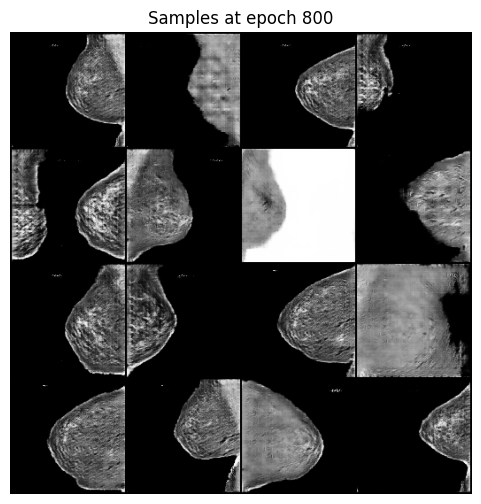

Epoch [801/1500] Loss_D: 0.4799 Loss_G: 3.3191 time:7.7s
Epoch [802/1500] Loss_D: 0.3610 Loss_G: 4.0801 time:7.6s
Epoch [803/1500] Loss_D: 3.0611 Loss_G: 2.1169 time:7.7s
Epoch [804/1500] Loss_D: 1.4235 Loss_G: 4.4452 time:7.6s
Epoch [805/1500] Loss_D: 0.5810 Loss_G: 3.9740 time:7.7s
Epoch [806/1500] Loss_D: 0.3375 Loss_G: 8.1446 time:7.7s
Epoch [807/1500] Loss_D: 3.5875 Loss_G: 3.0215 time:7.7s
Epoch [808/1500] Loss_D: 1.3295 Loss_G: 5.3684 time:7.8s
Epoch [809/1500] Loss_D: 1.5416 Loss_G: 6.6043 time:7.7s
Epoch [810/1500] Loss_D: 0.3858 Loss_G: 6.4746 time:7.5s
Epoch [811/1500] Loss_D: 0.3713 Loss_G: 4.8257 time:7.7s
Epoch [812/1500] Loss_D: 1.1061 Loss_G: 2.6924 time:7.7s
Epoch [813/1500] Loss_D: 1.9652 Loss_G: 2.8155 time:7.6s
Epoch [814/1500] Loss_D: 1.1274 Loss_G: 4.4117 time:7.6s
Epoch [815/1500] Loss_D: 0.8012 Loss_G: 2.9100 time:7.6s
Epoch [816/1500] Loss_D: 1.5967 Loss_G: 1.2506 time:7.5s
Epoch [817/1500] Loss_D: 0.6922 Loss_G: 5.7056 time:7.7s
Epoch [818/1500] Loss_D: 2.0465

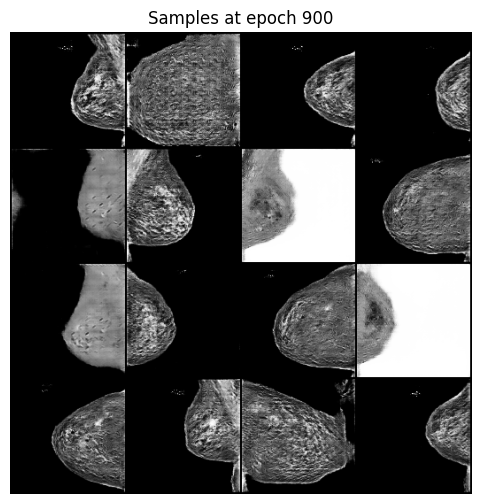

Epoch [901/1500] Loss_D: 0.5954 Loss_G: 4.2022 time:7.5s
Epoch [902/1500] Loss_D: 1.0096 Loss_G: 4.3235 time:7.5s
Epoch [903/1500] Loss_D: 0.5859 Loss_G: 4.0046 time:7.5s
Epoch [904/1500] Loss_D: 0.8479 Loss_G: 4.1788 time:7.5s
Epoch [905/1500] Loss_D: 0.8141 Loss_G: 4.6855 time:7.5s
Epoch [906/1500] Loss_D: 0.4902 Loss_G: 3.4140 time:7.5s
Epoch [907/1500] Loss_D: 1.2791 Loss_G: 1.6297 time:7.5s
Epoch [908/1500] Loss_D: 1.8520 Loss_G: 0.9747 time:7.5s
Epoch [909/1500] Loss_D: 0.7459 Loss_G: 6.5272 time:7.5s
Epoch [910/1500] Loss_D: 1.0476 Loss_G: 4.0820 time:7.5s
Epoch [911/1500] Loss_D: 0.5373 Loss_G: 3.1494 time:7.5s
Epoch [912/1500] Loss_D: 0.4312 Loss_G: 6.0352 time:7.5s
Epoch [913/1500] Loss_D: 0.9192 Loss_G: 4.4414 time:7.5s
Epoch [914/1500] Loss_D: 1.1991 Loss_G: 3.5150 time:7.5s
Epoch [915/1500] Loss_D: 0.4342 Loss_G: 11.5169 time:7.5s
Epoch [916/1500] Loss_D: 0.4191 Loss_G: 6.3607 time:7.5s
Epoch [917/1500] Loss_D: 0.4029 Loss_G: 5.1449 time:7.5s
Epoch [918/1500] Loss_D: 0.374

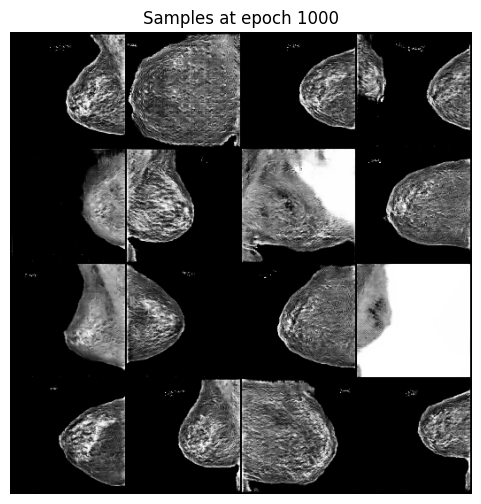

Epoch [1001/1500] Loss_D: 0.5059 Loss_G: 10.3358 time:7.5s
Epoch [1002/1500] Loss_D: 0.3586 Loss_G: 8.0375 time:7.7s
Epoch [1003/1500] Loss_D: 0.4631 Loss_G: 4.7156 time:7.5s
Epoch [1004/1500] Loss_D: 1.0054 Loss_G: 8.3081 time:7.5s
Epoch [1005/1500] Loss_D: 2.5770 Loss_G: 2.5296 time:7.6s
Epoch [1006/1500] Loss_D: 1.4760 Loss_G: 5.0890 time:7.5s
Epoch [1007/1500] Loss_D: 0.4632 Loss_G: 4.5891 time:7.5s
Epoch [1008/1500] Loss_D: 1.8304 Loss_G: 4.2014 time:7.6s
Epoch [1009/1500] Loss_D: 0.4275 Loss_G: 8.2613 time:7.5s
Epoch [1010/1500] Loss_D: 0.4452 Loss_G: 4.0255 time:7.5s
Epoch [1011/1500] Loss_D: 0.5918 Loss_G: 4.0884 time:7.5s
Epoch [1012/1500] Loss_D: 0.5639 Loss_G: 2.4243 time:7.5s
Epoch [1013/1500] Loss_D: 0.9309 Loss_G: 4.0947 time:7.5s
Epoch [1014/1500] Loss_D: 0.5253 Loss_G: 3.3716 time:7.5s
Epoch [1015/1500] Loss_D: 0.4935 Loss_G: 7.9197 time:7.5s
Epoch [1016/1500] Loss_D: 0.5008 Loss_G: 5.1113 time:7.5s
Epoch [1017/1500] Loss_D: 0.5580 Loss_G: 3.6986 time:7.5s
Epoch [1018/1

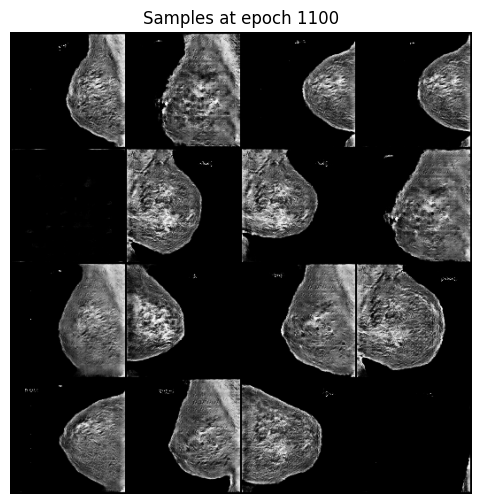

Epoch [1101/1500] Loss_D: 0.4053 Loss_G: 9.5195 time:7.5s
Epoch [1102/1500] Loss_D: 1.2994 Loss_G: 1.9954 time:7.7s
Epoch [1103/1500] Loss_D: 0.4098 Loss_G: 9.0290 time:7.5s
Epoch [1104/1500] Loss_D: 0.3770 Loss_G: 6.9164 time:7.7s
Epoch [1105/1500] Loss_D: 0.5061 Loss_G: 4.0638 time:7.5s
Epoch [1106/1500] Loss_D: 0.9125 Loss_G: 2.5660 time:7.5s
Epoch [1107/1500] Loss_D: 2.2464 Loss_G: 2.6692 time:7.5s
Epoch [1108/1500] Loss_D: 0.3558 Loss_G: 6.0787 time:7.5s
Epoch [1109/1500] Loss_D: 0.6428 Loss_G: 3.1957 time:7.5s
Epoch [1110/1500] Loss_D: 0.5556 Loss_G: 9.0697 time:7.5s
Epoch [1111/1500] Loss_D: 0.4883 Loss_G: 3.5082 time:7.5s
Epoch [1112/1500] Loss_D: 1.4294 Loss_G: 3.6741 time:7.5s
Epoch [1113/1500] Loss_D: 1.5731 Loss_G: 3.0489 time:7.5s
Epoch [1114/1500] Loss_D: 1.2567 Loss_G: 3.5530 time:7.5s
Epoch [1115/1500] Loss_D: 0.3867 Loss_G: 4.0540 time:7.5s
Epoch [1116/1500] Loss_D: 0.3549 Loss_G: 9.3385 time:7.5s
Epoch [1117/1500] Loss_D: 0.3428 Loss_G: 7.7885 time:7.5s
Epoch [1118/15

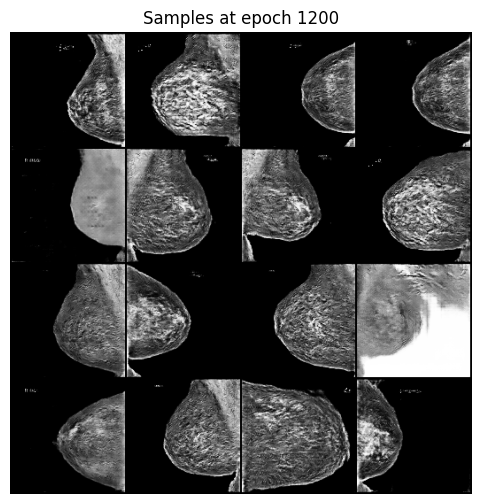

Epoch [1201/1500] Loss_D: 0.5684 Loss_G: 2.2179 time:7.5s
Epoch [1202/1500] Loss_D: 0.6782 Loss_G: 1.5555 time:7.5s
Epoch [1203/1500] Loss_D: 0.5293 Loss_G: 5.5367 time:7.5s
Epoch [1204/1500] Loss_D: 0.5092 Loss_G: 5.5452 time:7.5s
Epoch [1205/1500] Loss_D: 0.8753 Loss_G: 1.8696 time:7.5s
Epoch [1206/1500] Loss_D: 0.5968 Loss_G: 7.1600 time:7.5s
Epoch [1207/1500] Loss_D: 0.5406 Loss_G: 5.4112 time:7.5s
Epoch [1208/1500] Loss_D: 0.4007 Loss_G: 3.7717 time:7.5s
Epoch [1209/1500] Loss_D: 0.6456 Loss_G: 3.3505 time:7.5s
Epoch [1210/1500] Loss_D: 1.1933 Loss_G: 7.9138 time:7.5s
Epoch [1211/1500] Loss_D: 0.4541 Loss_G: 4.7121 time:7.5s
Epoch [1212/1500] Loss_D: 0.3678 Loss_G: 4.7128 time:7.5s
Epoch [1213/1500] Loss_D: 0.3501 Loss_G: 9.6248 time:7.5s
Epoch [1214/1500] Loss_D: 0.6671 Loss_G: 6.9836 time:7.5s
Epoch [1215/1500] Loss_D: 0.5021 Loss_G: 3.6637 time:7.5s
Epoch [1216/1500] Loss_D: 1.2949 Loss_G: 2.4274 time:7.5s
Epoch [1217/1500] Loss_D: 0.3380 Loss_G: 9.9214 time:7.5s
Epoch [1218/15

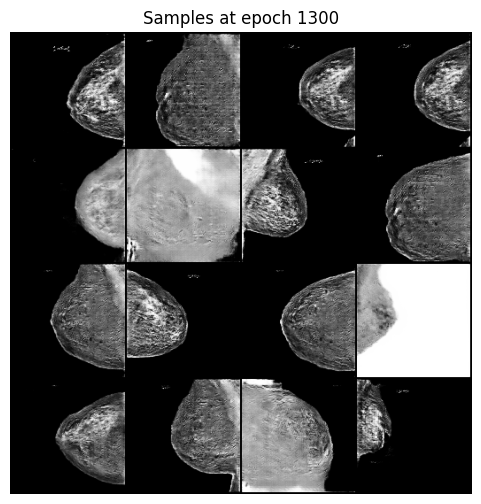

Epoch [1301/1500] Loss_D: 0.4012 Loss_G: 9.9738 time:7.5s
Epoch [1302/1500] Loss_D: 0.4586 Loss_G: 2.8047 time:7.5s
Epoch [1303/1500] Loss_D: 0.3620 Loss_G: 5.7335 time:7.5s
Epoch [1304/1500] Loss_D: 0.8443 Loss_G: 3.2560 time:7.5s
Epoch [1305/1500] Loss_D: 0.5439 Loss_G: 5.4239 time:7.5s
Epoch [1306/1500] Loss_D: 0.4788 Loss_G: 3.4583 time:7.5s
Epoch [1307/1500] Loss_D: 0.3342 Loss_G: 6.3019 time:7.5s
Epoch [1308/1500] Loss_D: 0.4421 Loss_G: 7.4023 time:7.7s
Epoch [1309/1500] Loss_D: 0.4906 Loss_G: 4.7133 time:7.5s
Epoch [1310/1500] Loss_D: 0.4465 Loss_G: 5.3834 time:7.6s
Epoch [1311/1500] Loss_D: 0.4082 Loss_G: 5.0111 time:7.5s
Epoch [1312/1500] Loss_D: 0.3775 Loss_G: 4.5929 time:7.7s
Epoch [1313/1500] Loss_D: 0.4797 Loss_G: 4.9481 time:7.6s
Epoch [1314/1500] Loss_D: 0.3875 Loss_G: 8.1843 time:7.5s
Epoch [1315/1500] Loss_D: 0.6177 Loss_G: 5.3194 time:7.5s
Epoch [1316/1500] Loss_D: 0.3542 Loss_G: 9.5703 time:7.5s
Epoch [1317/1500] Loss_D: 0.4139 Loss_G: 4.5236 time:7.5s
Epoch [1318/15

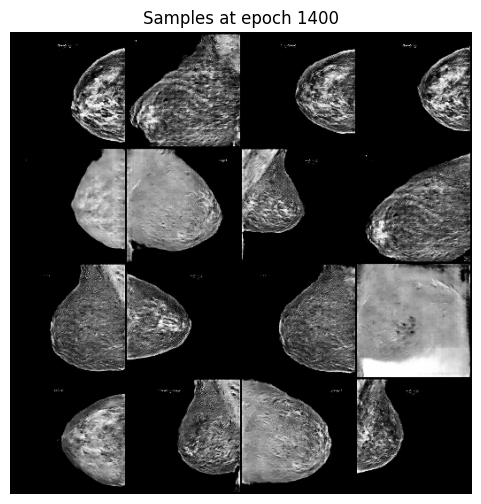

Epoch [1401/1500] Loss_D: 0.3990 Loss_G: 3.8617 time:7.5s
Epoch [1402/1500] Loss_D: 0.5609 Loss_G: 5.9312 time:7.7s
Epoch [1403/1500] Loss_D: 0.3515 Loss_G: 7.0016 time:7.6s
Epoch [1404/1500] Loss_D: 0.6339 Loss_G: 5.5809 time:7.7s
Epoch [1405/1500] Loss_D: 0.3564 Loss_G: 6.9976 time:7.5s
Epoch [1406/1500] Loss_D: 0.5127 Loss_G: 5.3417 time:7.5s
Epoch [1407/1500] Loss_D: 0.5892 Loss_G: 8.2494 time:7.5s
Epoch [1408/1500] Loss_D: 0.4981 Loss_G: 5.7504 time:7.5s
Epoch [1409/1500] Loss_D: 0.3751 Loss_G: 6.6599 time:7.7s
Epoch [1410/1500] Loss_D: 0.4626 Loss_G: 11.8503 time:7.6s
Epoch [1411/1500] Loss_D: 0.4305 Loss_G: 4.6809 time:7.6s
Epoch [1412/1500] Loss_D: 0.4337 Loss_G: 4.4967 time:7.5s
Epoch [1413/1500] Loss_D: 0.3856 Loss_G: 7.1828 time:7.5s
Epoch [1414/1500] Loss_D: 0.3679 Loss_G: 5.7237 time:7.5s
Epoch [1415/1500] Loss_D: 0.5437 Loss_G: 7.2498 time:7.5s
Epoch [1416/1500] Loss_D: 0.4022 Loss_G: 4.1705 time:7.5s
Epoch [1417/1500] Loss_D: 0.7286 Loss_G: 8.4048 time:7.5s
Epoch [1418/1

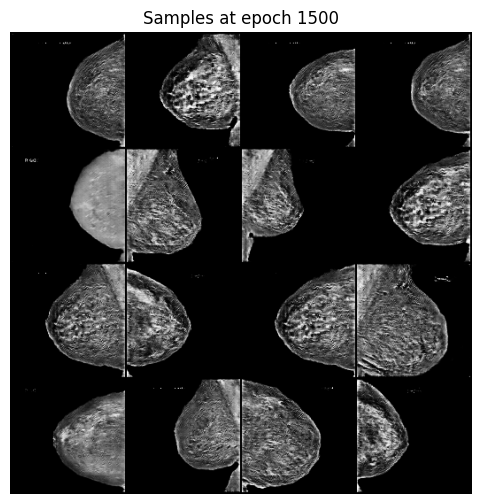

In [12]:
# ----------------------
# Training loop (GAN)
# ----------------------
start_epoch=0
for epoch in range(start_epoch, num_epochs):
    epoch_start = time.time()
    for i, (real_imgs, _) in enumerate(malignant_loader):
        real_imgs = real_imgs.to(device)          # shape [B,1,128,128]
        b_size = real_imgs.size(0)

        real_labels = torch.full((b_size,), 0.9, dtype=torch.float, device=device)  # label smoothing
        fake_labels = torch.zeros(b_size, dtype=torch.float, device=device)

        # Train Discriminator
        netD.zero_grad()
        
        output_real = netD(real_imgs)
        lossD_real = criterion(output_real, real_labels)

        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_imgs = netG(noise)
        output_fake = netD(fake_imgs.detach())
        lossD_fake = criterion(output_fake, fake_labels)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        output_fake_forG = netD(fake_imgs)
        lossG = criterion(output_fake_forG, real_labels)
        lossG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {lossD.item():.4f} Loss_G: {lossG.item():.4f} time:{time.time()-epoch_start:.1f}s")

    # ✅ Save checkpoints (every save_every epochs or last one)
    if (epoch+1) % save_every == 0 or (epoch+1) == num_epochs:
        torch.save({
            'epoch': epoch,
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
        }, CHECKPOINT_PATH)
        torch.save(netG.state_dict(), GEN_PATH)
        torch.save(netD.state_dict(), DISC_PATH)
        print(f"✅ Saved checkpoint at epoch {epoch+1}")

    # ✅ Show generated samples every 100 epochs
    if (epoch+1) % 100 == 0 or (epoch+1) == num_epochs:
        netG.eval()
        with torch.no_grad():
            gen = netG(fixed_noise).cpu()
            grid = torchvision.utils.make_grid(gen, nrow=4, normalize=True)
            plt.figure(figsize=(6,6))
            plt.imshow(np.transpose(grid, (1,2,0)), cmap=None)
            plt.axis('off')
            plt.title(f"Samples at epoch {epoch+1}")
            plt.show()
        netG.train()


In [13]:
import torch
torch.save(netG.state_dict(), PRETRAINED_GEN)
print("Pretrained generator saved at:", PRETRAINED_GEN)


Pretrained generator saved at: /kaggle/working/breast_gan_pipeline/pretrained_generator.pth


In [14]:
#generate synthetic images 
existing = len(glob(os.path.join(malignant_dir,"*.png"))) + len(glob(os.path.join(malignant_dir,"*.jpg")))
to_generate = max(0, target_malignant_total - existing)
print("Existing malignant:", existing, "Need to generate:", to_generate)

def generate_and_save(n, out_folder, batch=64):
    os.makedirs(out_folder, exist_ok=True)
    netG.eval()
    saved = 0
    idx = len(glob(os.path.join(out_folder,"*.png")))
    with torch.no_grad():
        while saved < n:
            cur = min(batch, n - saved)
            noise = torch.randn(cur, latent_dim, 1, 1, device=device)
            gen = netG(noise).cpu()  # [-1,1]
            gen = (gen * 0.5 + 0.5) * 255.0  # [0,255]
            gen = gen.squeeze(1).numpy().astype(np.uint8)  # shape [cur, H, W]
            for k in range(cur):
                fname = os.path.join(out_folder, f"gen_{idx:06d}.png")
                cv2.imwrite(fname, gen[k])
                idx += 1
            saved += cur
            print(f"Saved {saved}/{n} synthetic images", end='\r')
    netG.train()
    print()

if to_generate > 0:
    # generate in batches (may take time)
    print("Generating synthetic malignant images ...")
    generate_and_save(to_generate, synthetic_dir, batch=32)
else:
    print("No synthetic generation required (already >= target).")

Existing malignant: 1158 Need to generate: 50842
Generating synthetic malignant images ...
Saved 50842/50842 synthetic images


Total synthetic images available: 50842


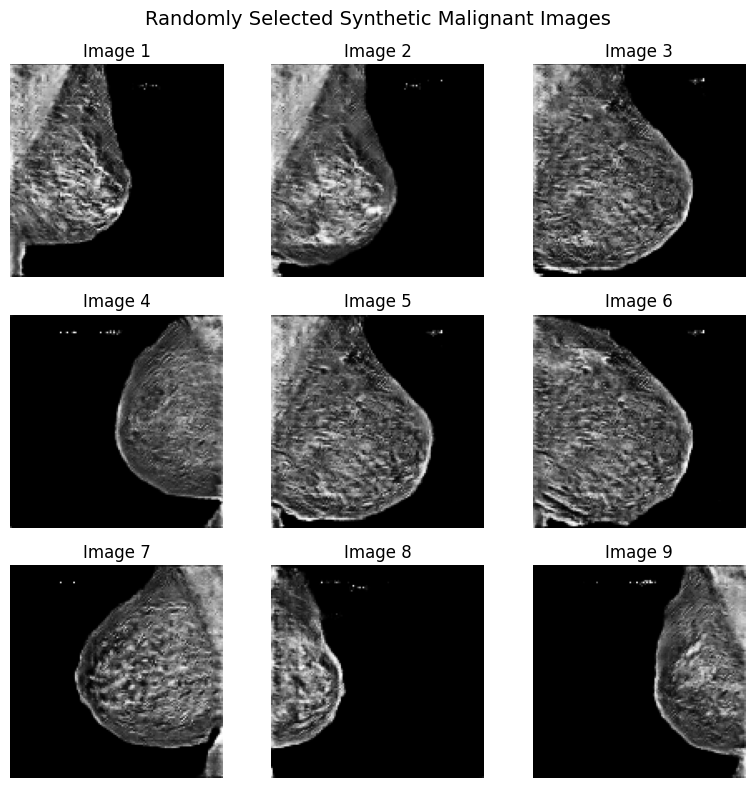

In [16]:
# ----------------------
# View generated images
# ----------------------
import matplotlib.pyplot as plt
import random
from glob import glob

# get list of generated files
gen_files = sorted(glob(os.path.join(synthetic_dir, "*.png")))
print(f"Total synthetic images available: {len(gen_files)}")

# randomly select 9 to view (or less if fewer exist)
sample_files = random.sample(gen_files, min(9, len(gen_files)))

# plot them in a 3x3 grid
plt.figure(figsize=(8, 8))
for i, f in enumerate(sample_files):
    img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
    plt.subplot(3, 3, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Image {i+1}")
plt.suptitle("Randomly Selected Synthetic Malignant Images", fontsize=14)
plt.tight_layout()
plt.show()


In [18]:
import shutil
# ----------------------
# Combine real + synthetic into combined_dir
# ----------------------
# Copy benign images
print("Combining datasets into", combined_dir)
def copy_all(src_folder, dst_folder):
    os.makedirs(dst_folder, exist_ok=True)
    files = sorted(glob(os.path.join(src_folder,"*.png")) + glob(os.path.join(src_folder,"*.jpg")))
    for f in files:
        dest = os.path.join(dst_folder, os.path.basename(f))
        if not os.path.exists(dest):
            shutil.copy(f, dest)

copy_all(benign_dir, combined_benign_dir)
copy_all(malignant_dir, combined_malignant_dir)
copy_all(synthetic_dir, combined_malignant_dir)

print("Combined counts - benign:", len(os.listdir(combined_benign_dir)),
      "malignant:", len(os.listdir(combined_malignant_dir)))

Combining datasets into /kaggle/working/breast_gan_pipeline/combined_dataset
Combined counts - benign: 53548 malignant: 52000


In [19]:
# ----------------------
# Prepare dataset for classification (train/val split)
# ----------------------
from sklearn.model_selection import train_test_split
def build_image_paths_labels(root_dir):
    X, y = [], []
    for label in ["0","1"]:
        folder = os.path.join(root_dir, label)
        files = sorted(glob(os.path.join(folder,"*.png")) + glob(os.path.join(folder,"*.jpg")))
        for f in files:
            X.append(f)
            y.append(int(label))
    return X, y

X, y = build_image_paths_labels(combined_dir)
print("Total combined images:", len(X))
# shuffle & split (80/20)
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train/Val sizes:", len(train_X), len(val_X))

# Dataset loader for classifier (with same preprocessing but produce 3-channel or 1-channel appropriate)
class ClassifierDataset(Dataset):
    def __init__(self, files, labels, size=img_size, transform=None):
        self.files = files
        self.labels = labels
        self.size = size
        self.transform = transform
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        p = self.files[idx]
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.size, self.size))
        img = img.astype(np.float32) / 255.0
        img = (img - 0.5) / 0.5  # [-1,1]
        img = np.expand_dims(img, 0)  # channel first
        img = torch.tensor(img, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

train_ds = ClassifierDataset(train_X, train_y, size=img_size)
val_ds = ClassifierDataset(val_X, val_y, size=img_size)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


Total combined images: 105548
Train/Val sizes: 84438 21110


In [20]:
benign_dir = "/kaggle/input/mammography-breast-cancer-detection/train/0"
malignant_dir = "/kaggle/input/mammography-breast-cancer-detection/train/1"

benign_count = len(os.listdir(benign_dir))
malignant_count = len(os.listdir(malignant_dir))
print(f"Benign: {benign_count}, Malignant: {malignant_count}")


Benign: 53548, Malignant: 1158


In [21]:
import os

# ✅ Use your actual combined dataset paths
benign_dir = "/kaggle/working/breast_gan_pipeline/combined_dataset/0"
malignant_dir = "/kaggle/working/breast_gan_pipeline/combined_dataset/1"

benign_count = len(os.listdir(benign_dir))
malignant_count = len(os.listdir(malignant_dir))

print(f"✅ Benign Images: {benign_count}")
print(f"✅ Malignant Images: {malignant_count}")
print(f"✅ Total Images: {benign_count + malignant_count}")


✅ Benign Images: 53548
✅ Malignant Images: 52000
✅ Total Images: 105548


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import gradio as gr
import cv2
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------
# Corrected CNN Model
# ----------------------
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Adapt to img_size dynamically
        dummy_input = torch.zeros(1, 1, img_size, img_size)
        out = self._forward_features(dummy_input)
        flattened_size = out.view(1, -1).size(1)

        self.fc1 = nn.Linear(flattened_size, 256)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 2)

    def _forward_features(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

# ----------------------
# Training
# ----------------------
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 20
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.znghnero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/20] Loss: 0.0779
Epoch [2/20] Loss: 0.0576
Epoch [3/20] Loss: 0.0548
Epoch [4/20] Loss: 0.0522
Epoch [5/20] Loss: 0.0502
Epoch [6/20] Loss: 0.0463
Epoch [7/20] Loss: 0.0438
Epoch [8/20] Loss: 0.0376
Epoch [9/20] Loss: 0.0329
Epoch [10/20] Loss: 0.0275
Epoch [11/20] Loss: 0.0237
Epoch [12/20] Loss: 0.0203
Epoch [13/20] Loss: 0.0168
Epoch [14/20] Loss: 0.0152
Epoch [15/20] Loss: 0.0131
Epoch [16/20] Loss: 0.0112
Epoch [17/20] Loss: 0.0106
Epoch [18/20] Loss: 0.0084
Epoch [19/20] Loss: 0.0087
Epoch [20/20] Loss: 0.0070


In [23]:
# ----------------------
# Evaluation
# ----------------------
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 98.72%


In [2]:
import torch
# ✅ Save your trained CNN model as a "pretrained" checkpoint
CNN_CHECKPOINT = "cnn_pretrained.pth"
torch.save(model.state_dict(), CNN_CHECKPOINT)
print(f"✅ CNN model saved as pretrained -> {CNN_CHECKPOINT}")


✅ CNN model saved as pretrained -> cnn_pretrained.pth


In [6]:
import gradio as gr
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np

# ----------------------
# Device Config
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 128  # should match training size

# ----------------------
# CNN Model Definition
# ----------------------
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64 * (img_size // 8) * (img_size // 8), 256)
        self.fc2 = nn.Linear(256, 2)  # output 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ----------------------
# Load Model
# ----------------------
model = CNNModel().to(device)
state_dict = torch.load("cnn_pretrained.pth", map_location=device)
model.load_state_dict(state_dict, strict=False)
model.eval()
print("✅ Model Loaded Successfully")

# ----------------------
# Helper: Mammogram Validation
# ----------------------
def is_mammogram(image):
    if len(image.shape) == 2:
        return True
    if len(image.shape) == 3:
        r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
        return np.mean(np.abs(r - g)) + np.mean(np.abs(g - b)) + np.mean(np.abs(r - b)) < 60
    return False

# ----------------------
# Stage Logic
# ----------------------
def get_stage(confidence):
    if confidence < 0.6:
        return "Stage I"
    elif confidence < 0.8:
        return "Stage II"
    else:
        return "Stage III"

# ----------------------
# Prediction Function
# ----------------------
def predict(img):
    if not is_mammogram(img):
        return "❌ Invalid image. Please upload a proper mammogram.", "N/A"

    # Convert to grayscale
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img

    # Resize and normalize (match training pipeline!)
    img_resized = cv2.resize(img_gray, (img_size, img_size))
    img_normalized = img_resized / 255.0  # keep in [0,1] if trained that way

    # Prepare tensor
    img_tensor = torch.tensor(img_normalized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)[0]
        pred_class = torch.argmax(probs).item()
        confidence = probs[pred_class].item()

    # 🔄 IMPORTANT: Swap class order if labels were reversed during training
    # If your training labels were 0=malignant, 1=benign, then flip this:
    class_labels = ["Benign", "Malignant"]  # try this first
    # If you still get wrong outputs, change it to:
    # class_labels = ["Malignant", "Benign"]

    predicted_label = class_labels[pred_class]

    if predicted_label == "Malignant":
        stage = get_stage(confidence)
        message = (
            f"⚠️ **Malignant Detected ({stage})**\n\n"
            f"🔢 Confidence: {confidence:.2f}\n\n"
            "🔹 Consult an oncologist for further evaluation.\n"
            "🔹 Early medical attention is recommended.\n"
        )
    else:
        stage = "No Cancer"
        message = (
            f"✅ **Benign:** No malignancy detected.\n\n"
            f"🔢 Confidence: {confidence:.2f}\n\n"
            "🟢 Continue regular screening as advised by your doctor."
        )

    return message, stage

# ----------------------
# Gradio UI
# ----------------------
ui = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy", label="📷 Upload Mammogram"),
    outputs=[
        gr.Textbox(label="🩺 Diagnosis & Recommendation", lines=10),
        gr.Textbox(label="📊 Detected Stage"),
    ],
    title="Breast Cancer Detection – Accurate AI Classifier",
    description=(
        "Upload a **mammogram image** to detect if it’s **Benign** or **Malignant** with stage estimation."
    ),
    theme="soft",
)

ui.launch(debug=True)


✅ Model Loaded Successfully
* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://a737c230228d089f86.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a737c230228d089f86.gradio.live
